# Diabetes prediction using Deep Learning

In [624]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

## 1. Data importing and pre-processing

### 1.1 Importing the dataset from `diabetes.csv` file

In [625]:
dataset_url = './diabetes.csv'
df = pd.read_csv(dataset_url)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [626]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


### 1.2 Check if dataset has missing values

In [627]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [628]:
df["Metabolic_index"] = df["Insulin"] * df["SkinThickness"]
df["Glucose-to-Insulin"] = df["Glucose"] / (df["Insulin"] + 1)
# put the otuput column to the end
df = df[[c for c in df if c not in ['Outcome']] + ['Outcome']]
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Metabolic_index,Glucose-to-Insulin,Outcome
0,6,148,72,35,0,33.6,0.627,50,0,148.000000,1
1,1,85,66,29,0,26.6,0.351,31,0,85.000000,0
2,8,183,64,0,0,23.3,0.672,32,0,183.000000,1
3,1,89,66,23,94,28.1,0.167,21,2162,0.936842,0
4,0,137,40,35,168,43.1,2.288,33,5880,0.810651,1
5,5,116,74,0,0,25.6,0.201,30,0,116.000000,0
6,3,78,50,32,88,31.0,0.248,26,2816,0.876404,1
7,10,115,0,0,0,35.3,0.134,29,0,115.000000,0
8,2,197,70,45,543,30.5,0.158,53,24435,0.362132,1
9,8,125,96,0,0,0.0,0.232,54,0,125.000000,1


In [629]:
# count blood pressurem,insulin 0 values
df[df["BloodPressure"] == 0].shape, df[df["Insulin"] == 0].shape

# remove the blood pressure and skin thickness 0 rows
df = df[df["BloodPressure"] != 0]
df = df[df["SkinThickness"] != 0]
df.shape

(539, 11)

### 1.3 Scale the data 

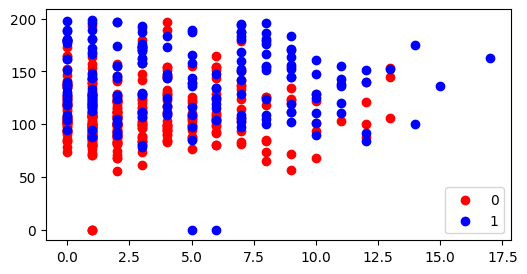

In [630]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]
# to numpy
X_np, y_np = X.to_numpy(), y.to_numpy()
plt.figure(figsize=(6, 3))
plt.scatter(X_np[y_np==0][:,0], X_np[y_np==0][:,1], color="red", label="0")
plt.scatter(X_np[y_np==1][:,0], X_np[y_np==1][:,1], color="blue", label="1")

plt.legend()
plt.show()

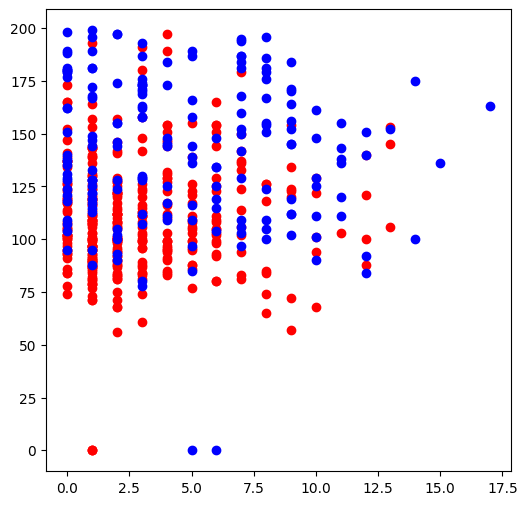

In [631]:
# new features for overlapping data
plt.figure(figsize=(6, 6))
plt.scatter(X_np[y_np==0][:,0], X_np[y_np==0][:,1], color="red", label="0")
plt.scatter(X_np[y_np==1][:,0], X_np[y_np==1][:,1], color="blue", label="1")

In [632]:
# Use standard scaler to scale the data to have mean 0 and variance 1
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X.shape, y.shape)
print(X[:5], y[:5])

(539, 10) (539,)
[[ 0.75796493  0.85532242  0.04383763  0.55676615 -0.92701638  0.11647585
   0.35404198  1.71866412 -0.79883874  2.19808556]
 [-0.75627932 -1.06001545 -0.44502753 -0.01557388 -0.92701638 -0.86359416
  -0.44190641 -0.05097586 -0.79883874  1.01153213]
 [-0.75627932 -0.93840669 -0.44502753 -0.5879139  -0.16063887 -0.65357916
  -0.97253868 -0.98236533 -0.30222118 -0.57172863]
 [-1.05912817  0.52089835 -2.56344325  0.55676615  0.44267959  1.44657087
   5.14415171  0.13530203  0.551814   -0.57410534]
 [-0.15058162 -1.27283076 -1.74866798  0.27059613 -0.20955659 -0.24755015
  -0.73894513 -0.51667059 -0.15199552 -0.57286692]] 0    1
1    0
3    0
4    1
6    1
Name: Outcome, dtype: int64


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
6            3       78             50             32       88  31.0   

   DiabetesPedigreeFunction  Age  Metabolic_index  Glucose-to-Insulin  Outcome  
0                     0.627   50                0          148.000000        1  
1                     0.351   31                0           85.000000        0  
3                     0.167   21             2162            0.936842        0  
4                     2.288   33             5880            0.810651        1  
6                     0.248   26             2816            0.876404        1  


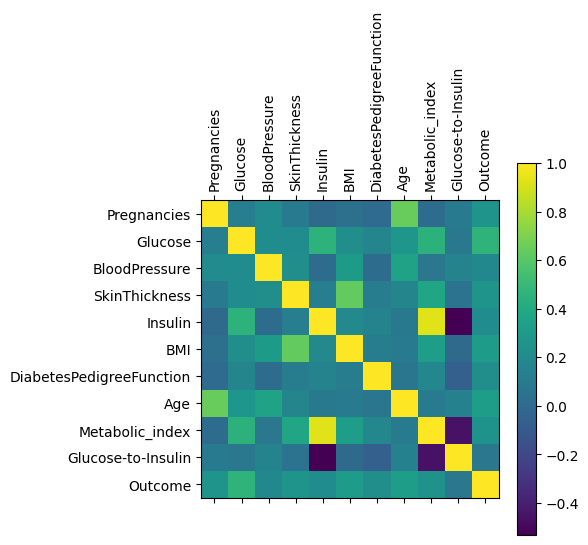

In [633]:
print(df.head())
corr = df.corr()

# plot correlation matrix
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()


In [634]:
corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Metabolic_index,Glucose-to-Insulin,Outcome
Pregnancies,1.000000,0.125243,0.206476,0.100132,-0.002677,0.031227,0.003232,0.644068,0.009963,0.098759,0.258883
Glucose,0.125243,1.000000,0.214644,0.210504,0.459620,0.226186,0.164368,0.270147,0.449578,0.082564,0.464195
BloodPressure,0.206476,0.214644,1.000000,0.226839,0.009534,0.300200,0.006749,0.347656,0.077099,0.153203,0.185618
SkinThickness,0.100132,0.210504,0.226839,1.000000,0.125794,0.632181,0.115938,0.166298,0.369838,0.051055,0.259199
Insulin,-0.002677,0.459620,0.009534,0.125794,1.000000,0.191364,0.149931,0.084478,0.924187,-0.532758,0.209954
BMI,0.031227,0.226186,0.300200,0.632181,0.191364,1.000000,0.113778,0.092539,0.324692,-0.003157,0.305894
DiabetesPedigreeFunction,0.003232,0.164368,0.006749,0.115938,0.149931,0.113778,1.000000,0.067456,0.173820,-0.060885,0.226655
Age,0.644068,0.270147,0.347656,0.166298,0.084478,0.092539,0.067456,1.000000,0.097598,0.138138,0.321420
Metabolic_index,0.009963,0.449578,0.077099,0.369838,0.924187,0.324692,0.173820,0.097598,1.000000,-0.459448,0.246474
Glucose-to-Insulin,0.098759,0.082564,0.153203,0.051055,-0.532758,-0.003157,-0.060885,0.138138,-0.459448,1.000000,0.073043


### 1.4 Convert the data to tensor to be used in pytorch

In [635]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
print(X.shape, y.shape)

torch.Size([539, 10]) torch.Size([539])


### 1.5 Split the dataset into test and training sets

In [636]:
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.8, random_state=42)
X_test.shape, X_train.shape, y_test.shape, y_train.shape

(torch.Size([107, 10]),
 torch.Size([432, 10]),
 torch.Size([107]),
 torch.Size([432]))

In [637]:
# show how many 0 and 1 in the training set
print(f"0: {y_train[y_train==0].shape[0]}, 1: {y_train[y_train==1].shape[0]}")

0: 291, 1: 141


## 2. Visualise the dataset

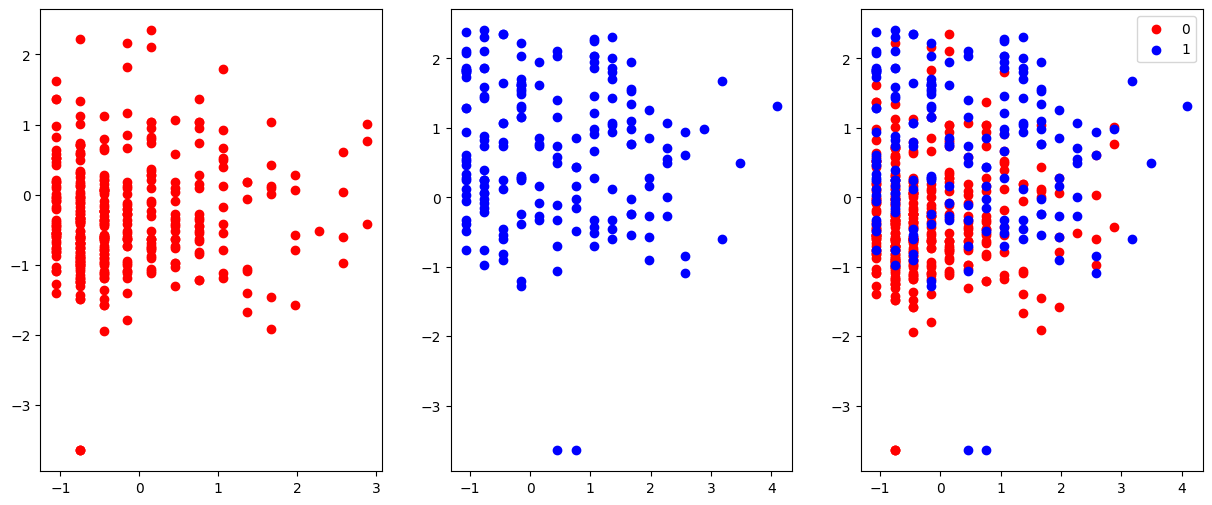

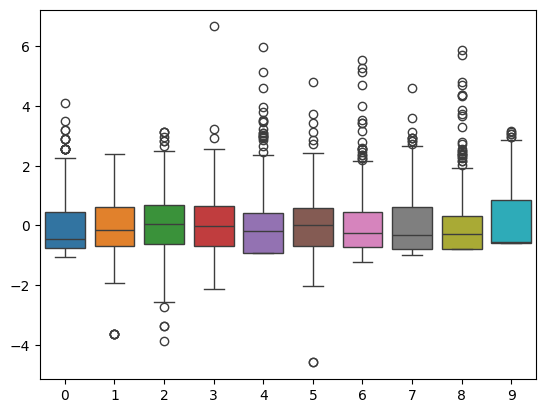

In [638]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.scatter(X[y==0][:,0], X[y==0][:,1], color="red", label="0")
plt.subplot(1, 3, 2)
plt.scatter(X[y==1][:,0], X[y==1][:,1], color="blue", label="1")
plt.subplot(1, 3, 3)
plt.scatter(X[y==0][:,0], X[y==0][:,1], color="red", label="0")
plt.scatter(X[y==1][:,0], X[y==1][:,1], color="blue", label="1")
plt.legend()
plt.show()
import seaborn as sns
sns.boxplot(data=X)
plt.show()

In [639]:
# create a model
class DiabetesClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_features = X.shape[1]
        self.fc1 = nn.Linear(self.input_features, 10)
        self.relu_1 = nn.ReLU()
        self.fc2 = nn.Linear(10, 16)
        self.relu_2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu_1(x)
        x = self.fc2(x)
        x = self.relu_2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
    
model = DiabetesClassifier()
model
next(model.parameters())

Parameter containing:
tensor([[ 0.2418,  0.2625, -0.0741,  0.2905, -0.0693,  0.0638, -0.1540,  0.1857,
          0.2788, -0.2320],
        [ 0.2749,  0.0592,  0.2336,  0.0428,  0.1525, -0.0446,  0.2438,  0.0467,
         -0.1476,  0.0806],
        [-0.1457, -0.0371, -0.1284,  0.2098, -0.2496, -0.1458, -0.0893, -0.1901,
          0.0298, -0.3123],
        [ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
          0.0346, -0.0997],
        [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
          0.1606, -0.1927],
        [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310,  0.1000, -0.0055,
          0.2475, -0.2247],
        [ 0.0199, -0.2158,  0.0975, -0.1089,  0.0969, -0.0659,  0.2623, -0.1874,
         -0.1886, -0.1886],
        [ 0.2844,  0.1054,  0.3043, -0.2610, -0.3137, -0.2474, -0.2127,  0.1281,
          0.1132,  0.2628],
        [-0.1633, -0.2156,  0.1678, -0.1278,  0.1919, -0.0750,  0.1809, -0.2457,
         -0.1596,  0.0964

In [640]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [641]:
from helper_functions import plot_decision_boundary, accuracy_fn

torch.manual_seed(42)
epochs = 2000
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(epochs):

    if epoch == 300:
        optimizer = optim.Adam(model.parameters(), lr=0.03)

    # Forward pass
    y_logits = model(X_train).squeeze()
    y_pred_labels = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    train_losses.append(loss.item())
    
    acc = accuracy_fn(y_train, y_pred_labels)
    train_accs.append(acc)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        y_test_logits = model(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
    test_loss = loss_fn(y_test_logits, y_test)
    test_losses.append(test_loss.item())
    test_acc = accuracy_fn(y_test, y_test_pred)
    test_accs.append(test_acc)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} Train Loss: {loss.item():.4f} Test Loss: {test_loss.item():.4f} Train Acc: {acc:.4f} Test Acc: {test_acc:.4f}")


Epoch: 0 Train Loss: 0.8015 Test Loss: 0.7386 Train Acc: 32.6389 Test Acc: 35.5140
Epoch: 10 Train Loss: 0.6722 Test Loss: 0.6624 Train Acc: 75.6944 Test Acc: 82.2430
Epoch: 20 Train Loss: 0.6472 Test Loss: 0.6449 Train Acc: 76.1574 Test Acc: 81.3084
Epoch: 30 Train Loss: 0.6407 Test Loss: 0.6419 Train Acc: 78.0093 Test Acc: 80.3738
Epoch: 40 Train Loss: 0.6388 Test Loss: 0.6469 Train Acc: 79.8611 Test Acc: 81.3084
Epoch: 50 Train Loss: 0.6401 Test Loss: 0.6510 Train Acc: 80.7870 Test Acc: 80.3738
Epoch: 60 Train Loss: 0.6376 Test Loss: 0.6452 Train Acc: 81.2500 Test Acc: 82.2430
Epoch: 70 Train Loss: 0.6361 Test Loss: 0.6431 Train Acc: 80.3241 Test Acc: 82.2430
Epoch: 80 Train Loss: 0.6358 Test Loss: 0.6432 Train Acc: 80.5556 Test Acc: 81.3084
Epoch: 90 Train Loss: 0.6358 Test Loss: 0.6379 Train Acc: 80.7870 Test Acc: 80.3738
Epoch: 100 Train Loss: 0.6368 Test Loss: 0.6404 Train Acc: 80.5556 Test Acc: 82.2430
Epoch: 110 Train Loss: 0.6358 Test Loss: 0.6430 Train Acc: 80.7870 Test Acc:

In [642]:
# implement our own decision boundary plot function without using plot_decision_boundary 
def plot_decision_boundary_local(X, y, model):
    # Create a figure
    plt.figure(figsize=(10, 6))
    
    # Get the first two features for visualization
    X_vis = X[:, :2]
    
    # Set the boundaries
    x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
    y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Create a grid of points with all other features set to their mean values
    input_data = torch.zeros((xx.ravel().shape[0], X.shape[1]), dtype=torch.float32)
    input_data[:, 0] = torch.tensor(xx.ravel(), dtype=torch.float32)
    input_data[:, 1] = torch.tensor(yy.ravel(), dtype=torch.float32)
    # Set remaining features to their mean values
    if X.shape[1] > 2:
        mean_vals = X[:, 2:].mean(dim=0)
        input_data[:, 2:] = mean_vals.repeat(xx.ravel().shape[0], 1)

    # Get predictions
    with torch.no_grad():
        Z = model(input_data)
        Z = torch.round(torch.sigmoid(Z))
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X_vis[y==0][:,0], X_vis[y==0][:,1], color="red", label="0")
    plt.scatter(X_vis[y==1][:,0], X_vis[y==1][:,1], color="blue", label="1")
    plt.legend()
    plt.show()

torch.Size([432, 10]) torch.Size([432])
Final accuracy: 83.17757009345794


C:\Users\rasim\AppData\Local\Temp\ipykernel_8608\3160094628.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
C:\Users\rasim\AppData\Local\Temp\ipykernel_8608\3160094628.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.arange(y_min, y_max, 0.1))


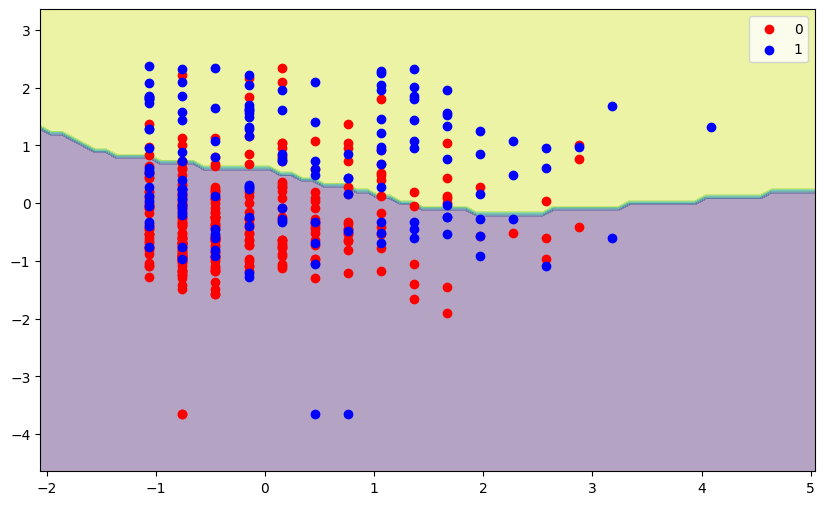

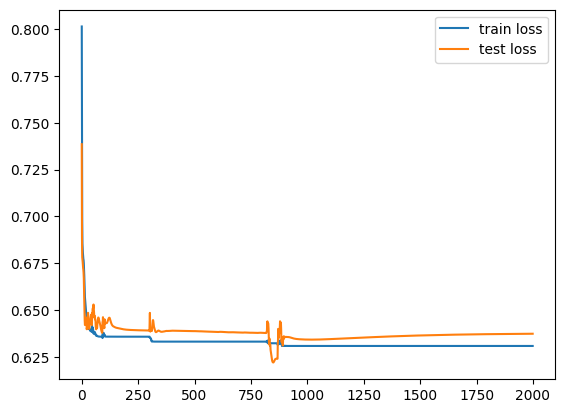

train loss: 0.6308547258377075, test loss: 0.6373822689056396


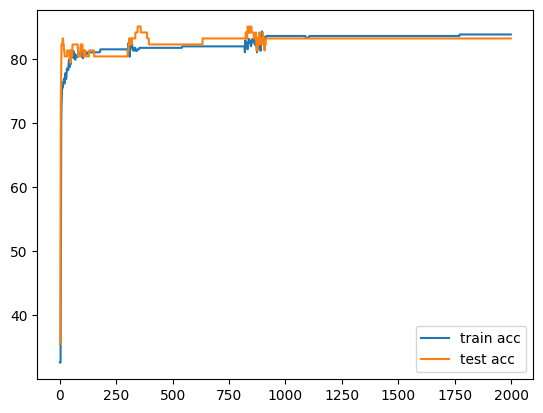

Final test accuracy: 83.17757009345794
Final train accuracy: 83.79629629629629


In [643]:

print(X_train.shape, y_train.shape)
print(f"Final accuracy: {test_accs[-1]}")

plot_decision_boundary_local(X_train, y_train, model)

# plot the loss
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

print(f"train loss: {train_losses[-1]}, test loss: {test_losses[-1]}")
# plot the accuracy
plt.plot(train_accs, label="train acc")
plt.plot(test_accs, label="test acc")
plt.legend()
plt.show()

print(f"Final test accuracy: {test_accs[-1]}")
print(f"Final train accuracy: {train_accs[-1]}")